<a href="https://colab.research.google.com/github/Kabongosalomon/Word-Embedding-Investigation/blob/master/An%20empirical%20investigation%20into%20the%20properties%20of%20standard%20word%20embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/Kabongosalomon/Data-Science-With-Jeff-Sander/master/aims-za-logo.jpg" width="100" alt="cognitiveclass.ai logo" />





# IMdb Sentiment Analysis Task

## Importing usefull packages 

In [1]:
# Import packages
import tensorflow as tf
# tf.enable_eager_execution()

from keras.datasets import imdb
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import losses
from keras import metrics
from keras import optimizers
from keras.layers import Dropout

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Downgrate numpy to fix a problem
!pip install numpy==1.16.2
import numpy as np
print(np.__version__)

import matplotlib.pyplot as plt

import os

import numpy as np

import string

!pip install ipdb
import ipdb # deb

from gensim.models.keyedvectors import KeyedVectors

# Spliting data
from sklearn.model_selection import train_test_split

from sklearn import metrics # For RUC

from nltk.stem import PorterStemmer

import tensorflow_hub as hub
import pandas as pd
import re
import seaborn as sns

# from google.colab import files

from IPython import display

import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

Using TensorFlow backend.
[nltk_data] Downloading package punkt to /home/aims/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/aims/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  Using cached https://files.pythonhosted.org/packages/91/e7/6c780e612d245cca62bc3ba8e263038f7c144a96a54f877f3714a0e8427e/numpy-1.16.2-cp37-cp37m-manylinux1_x86_64.whl
  Found existing installation: numpy 1.17.2
    Uninstalling numpy-1.17.2:
      Successfully uninstalled numpy-1.17.2
1.17.2


In [ ]:
link = "https://drive.google.com/file/d/1smGRs2g2HoI6VSvonoZmWKzXOP6uPUaW/view?usp=sharing"

_, id_t = link.split('d/')

id = id_t.split('/')[0]
print (id) # Verify that you have everything after '='

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


file_id = id
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

1smGRs2g2HoI6VSvonoZmWKzXOP6uPUaW


## Loading data (Manual)

If you want to manually load the data from a tex file 

In [ ]:
link = "https://drive.google.com/file/d/1smGRs2g2HoI6VSvonoZmWKzXOP6uPUaW/view?usp=sharing"

_, id_t = link.split('d/')

id = id_t.split('/')[0]
print (id) # Verify that you have everything after '='

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


file_id = id
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

In [ ]:
!ls

aclImdb.zip  crawl-300d-2M-subword.bin	crawl-300d-2M-subword.zip
adc.json     crawl-300d-2M-subword.vec	sample_data


In [ ]:
!unzip -qq aclImdb.zip

In [ ]:
!ls

In [ ]:
# imdb_dir = './data/aclImdb'
imdb_dir = './aclImdb'

# Reading in the training folder
train_dir = os.path.join(imdb_dir, 'train')
texts_tr_ = []
labels_tr = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts_tr_.append(f.read())
            f.close()
            if label_type == 'neg':
                labels_tr.append(0)
            else:
                labels_tr.append(1)

# Reading in the testing folder
train_dir = os.path.join(imdb_dir, 'test')
texts_tst_ = []
labels_tst = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts_tst_.append(f.read())
            f.close()
            if label_type == 'neg':
                labels_tst.append(0)
            else:
                labels_tst.append(1)

In [ ]:
# Make sure that we have only 1 and 2 in the label 
(np.unique(labels_tr), np.unique(labels_tst))

In [ ]:
len(labels_tr)

In [ ]:
# Looking at 2 examples
print(texts_tr_[1])
print(labels_tr[1])

print(texts_tst_[-10])
print(labels_tst[-10])

## Load pre-trained  embedding

In [ ]:
######################################################################################################
########################################## Fasttext###################################################

# 2 million word vectors trained with subword information on Common Crawl (600B tokens).
# link = "https://drive.google.com/file/d/1Z_-E-gvsBP5BnJFKvX4sVnBVchdoUwsx/view?usp=sharing"

# 1 million word vectors trained with subword infomation on Wikipedia 2017, 
# UMBC webbase corpus and statmt.org news dataset (16B tokens).
link = "https://drive.google.com/file/d/1lZhw_9cXME_eYbl1IwrMTyTEn6ONozgI/view?usp=sharing"

# crawl-300d-2M.vec.zip: 2 million word vectors trained on Common Crawl (600B tokens).
# link = "https://drive.google.com/file/d/1jkJmSpRVZr_V2vGGkLmoEio6eY2Q2el-/view?usp=sharing"
######################################################################################################
######################################### Word2vec ###################################################

# Developed by Tomas Mikolov at Google in 2013. Word2vec (https://code.google.com/archive/p/word2vec)
# dimensions capture specific semantic properties
# link = "https://drive.google.com/file/d/13NmrtF-HoGmdv_m3Ld4eGVTbIekOcNi_/view?usp=sharing"
######################################################################################################
########################################## Glove #####################################################

# Go to https://nlp.stanford.edu/projects/glove, and download the precomputed embeddings
# from 2014 English Wikipedia. It’s an 822 MB zip file called glove.6B.zip, 
# containing 100-dimensional embedding vectors for 400,000 words (or nonword tokens). Unzip it.
# link = "https://drive.google.com/file/d/1qlkC4-gpOhJVVvja8NEnnYPJFFzUu1CW/view?usp=sharing"
######################################################################################################



######################################################################################################

_, id_t = link.split('d/')


id = id_t.split('/')[0]
print (id) # Verify that you have everything after '='

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = id
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

1lZhw_9cXME_eYbl1IwrMTyTEn6ONozgI
     |████████████████████████████████| 993kB 6.6MB/s 


In [ ]:
!ls

adc.json  sample_data  wiki-news-300d-1M-subword.vec.zip


In [ ]:
# !unzip crawl-300d-2M.vec.zip
# !unzip crawl-300d-2M-subword.zip
!unzip wiki-news-300d-1M-subword.vec.zip
# !unzip glove.840B.300d.zip

Archive:  wiki-news-300d-1M-subword.vec.zip
  inflating: wiki-news-300d-1M-subword.vec  


In [ ]:
# !rm crawl-300d-2M.vec.zip

In [ ]:
!ls

 adc.json				'Training and Validation loss.png'
 sample_data				 wiki-news-300d-1M-subword.vec
'Training and validation accuracy.eps'	 wiki-news-300d-1M-subword.vec.zip


In [ ]:
# gensim_w2v = KeyedVectors.load_word2vec_format('./crawl-300d-2M.vec')
gensim_w2v = KeyedVectors.load_word2vec_format('./wiki-news-300d-1M-subword.vec')
# gensim_w2v = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)
# gensim_w2v = KeyedVectors.load_word2vec_format('./crawl-300d-2M-subword.bin')

W0521 18:59:08.737219 139952709396352 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead


In [ ]:
gensim_w2v['I'].shape

(300,)

In [ ]:
gensim_w2v["Hello"]

array([-0.0038,  0.0601,  0.0188,  0.0288,  0.0031, -0.0114,  0.015 ,
       -0.0148, -0.004 , -0.0307,  0.015 ,  0.0423,  0.0133,  0.0243,
       -0.0038,  0.0272,  0.0356, -0.0024,  0.0257, -0.0343, -0.008 ,
        0.0032,  0.0065,  0.0043,  0.0186,  0.0173,  0.0047,  0.0351,
        0.0249, -0.0264, -0.0262,  0.0177,  0.0399,  0.0346, -0.0193,
        0.0078,  0.0046, -0.0115,  0.0021, -0.0317, -0.0078, -0.0675,
       -0.0009, -0.0058,  0.005 ,  0.0385,  0.0162, -0.0008, -0.0287,
        0.0565,  0.0094, -0.0034,  0.052 , -0.0209,  0.0455,  0.0119,
        0.008 , -0.0217, -0.0714, -0.0148,  0.0285, -0.0107, -0.0339,
        0.001 , -0.0323,  0.0292,  0.0139,  0.0141,  0.012 ,  0.0052,
       -0.0153,  0.0006,  0.0195, -0.0176,  0.0104, -0.017 ,  0.014 ,
       -0.0169,  0.0068,  0.0106, -0.0219, -0.025 ,  0.029 , -0.0596,
       -0.0245, -0.015 , -0.0285, -0.0399,  0.0048,  0.0084, -0.005 ,
        0.0104, -0.093 , -0.0481,  0.0094,  0.0111,  0.0026,  0.0017,
       -0.0146, -0.0

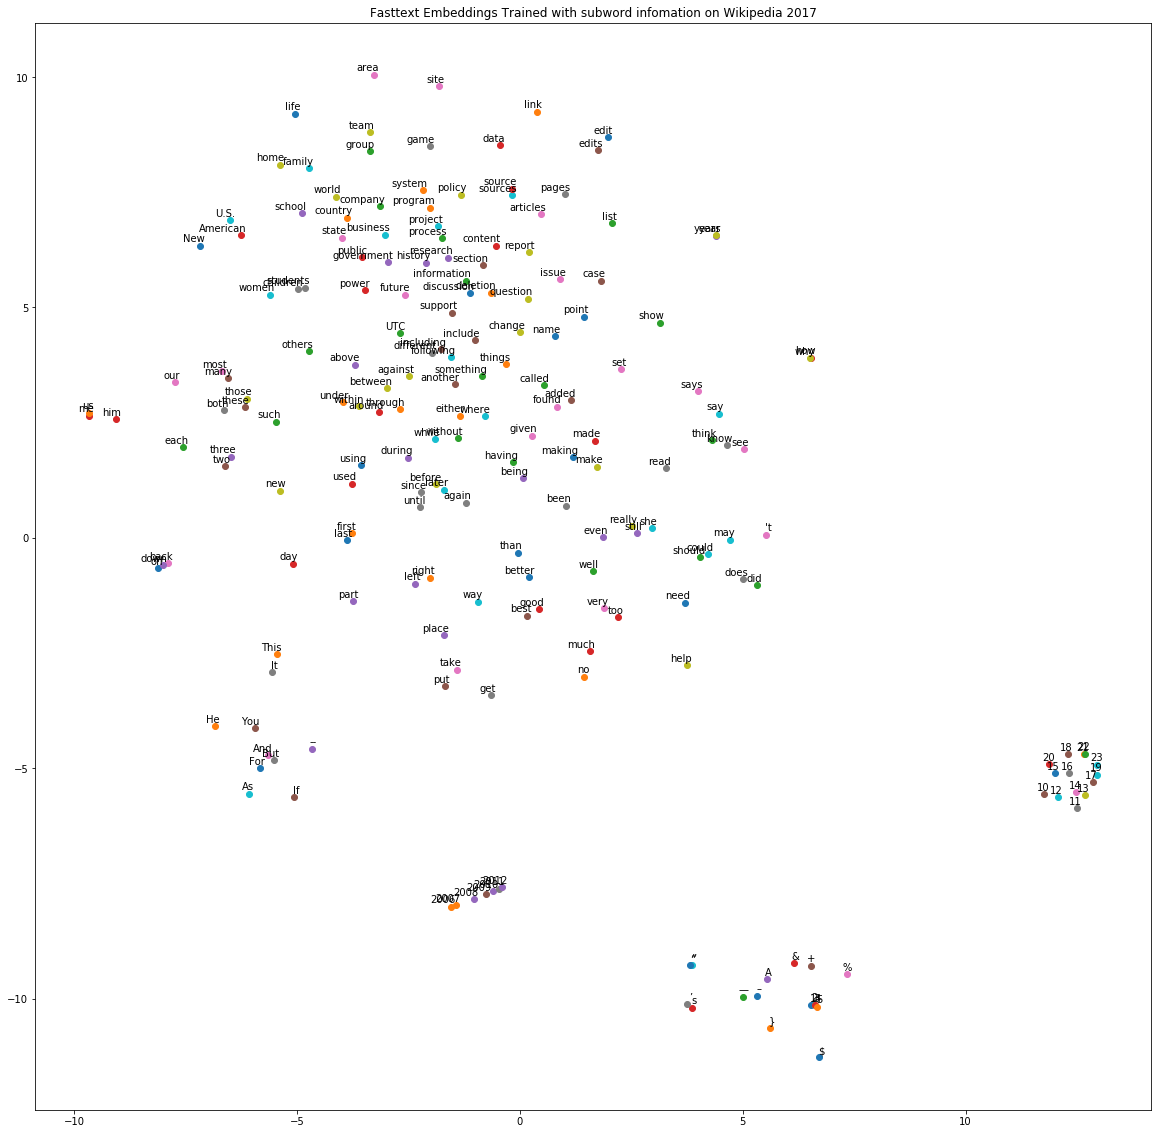

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pylab

words = [word for word in gensim_w2v.index2word[100:300]]
embeddings = [gensim_w2v[word] for word in words]
words_embedded = TSNE(n_components=2).fit_transform(embeddings)

pylab.figure(figsize=(20, 20))
for i, label in enumerate(words):
  x, y = words_embedded[i, :]
  pylab.scatter(x, y)
  pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                 ha='right', va='bottom')
  
pylab.title('Fasttext Embeddings Trained with subword infomation on Wikipedia 2017')
pylab.savefig("Fasttest300-dembeddings.eps", format='eps', dpi=1200)
# pylab.axes(False)
pylab.show()

In [ ]:
!ls

 adc.json			  sample_data
'Fasttest 300-d embeddings'	  wiki-news-300d-1M-subword.vec
'Fasttest 300-d embeddings.eps'   wiki-news-300d-1M-subword.vec.zip
 Fasttest300-dembeddings.eps


In [ ]:
files.download("Fasttest300-dembeddings.eps")

## Approach (TF-Hub)

In [2]:
# Install TF-Hub.
!pip install tensorflow-hub
!pip install seaborn

# Install Ipdb
!pip install ipdb

from tensorflow.python.data import Dataset

More detailed information about installing Tensorflow can be found at [https://www.tensorflow.org/install/](https://www.tensorflow.org/install/).

### Getting started

#### Data
We will try to solve the [Large Movie Review Dataset v1.0](http://ai.stanford.edu/~amaas/data/sentiment/) task from Mass et al. The dataset consists of IMDB movie reviews labeled by positivity from 1 to 10. The task is to label the reviews as **negative** or **positive**.

In [3]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
#   data["sentiment"] = []
  for file_path in os.listdir(directory):
    # changed tf.gfile by tf.io.gfile tf 2.0
    with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
#       data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))#; 
# ipdb.set_trace()
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["sentiment"] = 1
  neg_df["sentiment"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

train_df, test_df = download_and_load_datasets()

In [8]:
# pd.set_option('display.max_colwidth', 200)

In [4]:
train_df.head(10)

,sentence,sentiment
0,Kenny Doughty as Jed Willis is sexier in this ...,1
1,Having endured this inaccurate movie I will ad...,0
2,"A friend of mine recommended this movie, citin...",1
3,The Matador is better upon reflection because ...,1
4,"The progression of the plot is enough to ""rope...",0
5,Those 2 points are dedicated the reasonable pe...,0
6,"This is one of the most calming, relaxing, and...",1
7,"WWE's last PPV of 2006, proved to be a hit wit...",1
8,"What a gem of a movie, so good that they made ...",1
9,Let's set one thing straight: this movie does ...,1


In [5]:
test_df.tail(10)

,sentence,sentiment
24990,"yeesh,talk about craptastic.this thing is brut...",0
24991,I decided to watch this ultra-low budget film ...,0
24992,It didn't take too long after Halloween had ki...,0
24993,I thought this movie was absolutely hilarious....,1
24994,"I say Ben Johnson and my fellow Canadians say,...",0
24995,"Wow, I think the overall average rating of thi...",1
24996,I just got back from the GLBT Film Festival at...,1
24997,044: The Big Trail (1930) - released 10/24/193...,1
24998,** HERE BE SPOILERS ** <br /><br />Recap: Macl...,1
24999,I watched this movie three times at different ...,1


In [ ]:
test_df

### Model
#### Input functions

[Estimator framework](https://www.tensorflow.org/get_started/premade_estimators#overview_of_programming_with_estimators) provides [input functions](https://www.tensorflow.org/api_docs/python/tf/estimator/inputs/pandas_input_fn) that wrap Pandas dataframes.

In [ ]:
# Training input on the whole training set with no limit on training epochs.
# # Changed estimator.inputs.pandas_input_fn by tf.compat.v1.estimator.inputs.pandas_input_fn
# train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
#     train_df, train_df["sentiment"], num_echs=None, shuffle=True)
# # .head(10)
# # Prediction on the whole training set.
# predict_train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
#     train_df, train_df["sentiment"], shuffle=False)
# # Prediction on the test set.
# predict_test_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
#     test_df, test_df["sentiment"], shuffle=False)

In [6]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["sentiment"], num_epochs=None, shuffle=True)
# .head(10)
# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["sentiment"], shuffle=False)
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test_df, test_df["sentiment"], shuffle=False)

### Feature columns

TF-Hub provides a [feature column](https://github.com/tensorflow/hub/blob/master/docs/api_docs/python/hub/text_embedding_column.md) that applies a module on the given text feature and passes further the outputs of the module. In this tutorial we will be using the [nnlm-en-dim128 module](https://tfhub.dev/google/nnlm-en-dim128/1). For the purpose of this tutorial, the most important facts are:

* The module takes **a batch of sentences in a 1-D tensor of strings** as input.
* The module is responsible for **preprocessing of sentences** (e.g. removal of punctuation and splitting on spaces).
* The module works with any input (e.g. **nnlm-en-dim128** hashes words not present in vocabulary into ~20.000 buckets).

In [7]:
embedded_text_feature_column = hub.text_embedding_column(
    key="sentence", 
    module_spec="https://tfhub.dev/google/Wiki-words-250-with-normalization/1", trainable=True) # adding trainable to (True) 

### Estimator

For classification we can use a [DNN Classifier](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier) (note further remarks about different modelling of the label function at the end of the tutorial).

In [9]:
estimator = tf.estimator.DNNClassifier(
    hidden_units=[512, 511, 512],
    feature_columns=[embedded_text_feature_column],
    n_classes=2,
    optimizer=tf.train.AdamOptimizer(learning_rate=0.003))

### Training

Train the estimator for a reasonable amount of steps.

In [10]:
# Training for 20,000 steps means 128,000 training examples with the default
# batch size. This is roughly equivalent to 100 epochs since the training dataset
# contains 25,000 examples.
estimator.train(input_fn=train_input_fn, steps=20000);

KeyboardInterrupt: 

In [ ]:
# 100*1000/5

20000.0

### Prediction

Run predictions for both training and test set.

In [21]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print(f"Training set accuracy: {train_eval_result['accuracy']*100:.1f} %")
print(f"Test set accuracy: {test_eval_result['accuracy']*100:.1f} %")

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-12-24T11:22:28Z


INFO:tensorflow:Starting evaluation at 2019-12-24T11:22:28Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpuhnu7j4x/model.ckpt-196


INFO:tensorflow:Restoring parameters from /tmp/tmpuhnu7j4x/model.ckpt-196


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-12-24-11:23:08


INFO:tensorflow:Finished evaluation at 2019-12-24-11:23:08


INFO:tensorflow:Saving dict for global step 196: accuracy = 0.6654, accuracy_baseline = 0.5, auc = 0.7386924, auc_precision_recall = 0.73729104, average_loss = 0.6553721, global_step = 196, label/mean = 0.5, loss = 0.65532506, precision = 0.6355116, prediction/mean = 0.51865435, recall = 0.77568


INFO:tensorflow:Saving dict for global step 196: accuracy = 0.6654, accuracy_baseline = 0.5, auc = 0.7386924, auc_precision_recall = 0.73729104, average_loss = 0.6553721, global_step = 196, label/mean = 0.5, loss = 0.65532506, precision = 0.6355116, prediction/mean = 0.51865435, recall = 0.77568


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 196: /tmp/tmpuhnu7j4x/model.ckpt-196


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 196: /tmp/tmpuhnu7j4x/model.ckpt-196


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-12-24T11:23:19Z


INFO:tensorflow:Starting evaluation at 2019-12-24T11:23:19Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpuhnu7j4x/model.ckpt-196


INFO:tensorflow:Restoring parameters from /tmp/tmpuhnu7j4x/model.ckpt-196


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-12-24-11:24:00


INFO:tensorflow:Finished evaluation at 2019-12-24-11:24:00


INFO:tensorflow:Saving dict for global step 196: accuracy = 0.6574, accuracy_baseline = 0.5, auc = 0.7281414, auc_precision_recall = 0.7253007, average_loss = 0.6574305, global_step = 196, label/mean = 0.5, loss = 0.65742254, precision = 0.63006544, prediction/mean = 0.5172086, recall = 0.76248


INFO:tensorflow:Saving dict for global step 196: accuracy = 0.6574, accuracy_baseline = 0.5, auc = 0.7281414, auc_precision_recall = 0.7253007, average_loss = 0.6574305, global_step = 196, label/mean = 0.5, loss = 0.65742254, precision = 0.63006544, prediction/mean = 0.5172086, recall = 0.76248


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 196: /tmp/tmpuhnu7j4x/model.ckpt-196


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 196: /tmp/tmpuhnu7j4x/model.ckpt-196


Training set accuracy: 66.5 %
Test set accuracy: 65.7 %


In [ ]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print(f"Training set accuracy: {train_eval_result['accuracy']*100:.1f} %")
print(f"Test set accuracy: {test_eval_result['accuracy']*100:.1f} %")

Training set accuracy: 100.0 %
Test set accuracy: 86.6 %


In [ ]:
print("Training set metrics:")
for m in train_eval_result:
  print(m, train_eval_result[m])
  
print("\n-----------------------------------\n")

print("Testing set metrics:")
for m in test_eval_result:
  print(m, test_eval_result[m])
# print("---")

Training set metrics:
accuracy 1.0
accuracy_baseline 0.5
auc 1.0
auc_precision_recall 1.0
average_loss 4.2935313e-05
label/mean 0.5
loss 0.005476443
precision 1.0
prediction/mean 0.50000554
recall 1.0
global_step 20000

-----------------------------------

Testing set metrics:
accuracy 0.86576
accuracy_baseline 0.5
auc 0.90123457
auc_precision_recall 0.91897255
average_loss 1.144381
label/mean 0.5
loss 145.96698
precision 0.8721309
prediction/mean 0.4916909
recall 0.8572
global_step 20000


### Evaluation


<function matplotlib.pyplot.show>

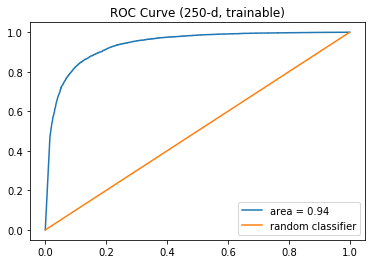

In [ ]:
from sklearn.metrics import auc
validation_probabilities = estimator.predict(input_fn=predict_test_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    test_df["sentiment"], validation_probabilities)


roc_auc = auc(false_positive_rate,true_positive_rate)
plt.plot(false_positive_rate,true_positive_rate,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], label="random classifier")
plt.title("ROC Curve (250-d, trainable)")
plt.legend(loc=0)
plt.savefig("ROC curve (250).eps", format='eps', dpi=1200)
plt.show

###Confusion matrix

We can visually check the confusion matrix to understand the distribution of misclassifications.

[]

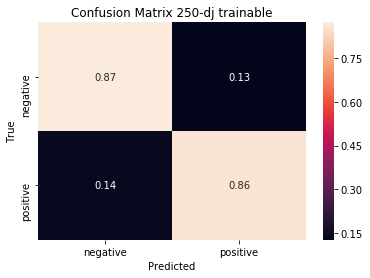

In [ ]:
def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
  cm = tf.confusion_matrix(test_df["sentiment"], 
                           get_predictions(estimator, predict_test_input_fn))
  with tf.Session() as session:
    cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");
plt.title("Confusion Matrix 250-dj trainable")
plt.savefig("Confusion matrix (250).eps", format='eps', dpi=1000)
plt.plot()

In [ ]:
!ls

'Confusion matrix (250).eps'  'ROC curve (250).png'
'ROC curve (250).eps'	       sample_data


In [ ]:
# files.download("Confusion matrix (250).eps")
files.download("ROC curve (250).eps")
# files.download("ROC curve (Bow+Fast_text).eps")

In [ ]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels
  
def preprocess_targets(dataframe_):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Create a boolean categorical feature representing whether the
  # median_house_value is above a set threshold.
  output_targets["sentiment"] = (dataframe_["sentiment"]).astype(float)
  return output_targets

In [ ]:
def train_DNN_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network classifier model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  periods = 10
  steps_per_period = steps / periods
  
  estimator = tf.estimator.DNNClassifier(
    hidden_units=[512],
    feature_columns=[embedded_text_feature_column],
    n_classes=2,
    optimizer=tf.train.AdagradOptimizer(learning_rate=learning_rate))
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["sentiment"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["sentiment"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["sentiment"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on training data):")
  
  training_log_losses = []
  validation_log_losses = []
  
  training_acc = []
  validation_acc = []

  for period in range (0, periods):
    # Train the model, starting from the prior state.
    estimator.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    
    # Take a break and compute predictions.    
    training_probabilities_acc = estimator.predict(input_fn=predict_training_input_fn)
    training_probabilities_acc = np.array([item['probabilities'][1] for item in training_probabilities_acc])
    
    validation_probabilities_acc = estimator.predict(input_fn=predict_validation_input_fn)
    validation_probabilities_acc = np.array([item['probabilities'][1] for item in validation_probabilities_acc])

    
    training_acc_ = metrics.accuracy_score(training_targets["sentiment"], training_probabilities_acc.round())
    validation_acc_ = metrics.accuracy_score(validation_targets["sentiment"], validation_probabilities_acc.round())
    
    # Take a break and compute predictions.    
    training_probabilities = estimator.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = estimator.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
    
    training_acc.append(training_acc_)
    validation_acc.append(validation_acc_)
    
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods (250-dimension Embeddings)")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()
  plt.show()
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("Accuracy")
  plt.xlabel("Periods")
  plt.title("Accuracy vs. Periods (250-dimension Embeddings)")
  plt.tight_layout()
  plt.plot(training_acc, label="training")
  plt.plot(validation_acc, label="validation")
  plt.legend()
  plt.show()
  
  validation_probabilities_f = estimator.predict(input_fn=predict_test_input_fn)
  # Get just the probabilities for the positive class.
  validation_probabilities_f = np.array([item['probabilities'][1] for item in validation_probabilities_f])

  false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
      test_df["sentiment"], validation_probabilities_f)
  plt.plot(false_positive_rate, true_positive_rate, label="our model")
  plt.plot([0, 1], [0, 1], label="random classifier")
  _ = plt.legend(loc=0)
  plt.title("ROC curve (250-dimension Embeddings)")
  plt.show()
  
  train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
  test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)
  
  print(f"Training set accuracy: {train_eval_result['accuracy']*100:.1f} %")
  print(f"Test set accuracy: {test_eval_result['accuracy']*100:.1f} %")

  return estimator

In [ ]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = train_df.head(20000)
training_targets = preprocess_targets(train_df.head(20000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = train_df.tail(5000)
validation_targets = preprocess_targets(train_df.tail(5000))

Training model...
LogLoss (on training data):
  period 00 : 0.61
  period 01 : 0.60
  period 02 : 0.58
  period 03 : 0.56
  period 04 : 0.55
  period 05 : 0.54
  period 06 : 0.56
  period 07 : 0.53
  period 08 : 0.52
  period 09 : 0.52
Model training finished.


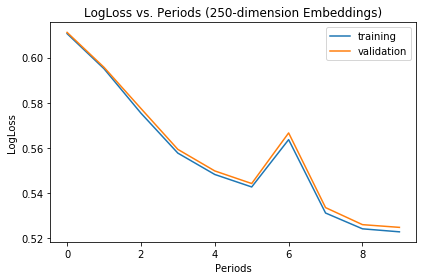

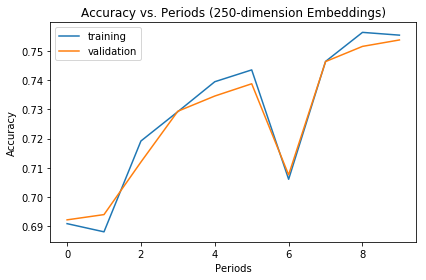

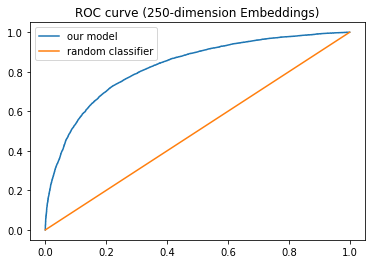

Training set accuracy: 75.5 %
Test set accuracy: 74.6 %


In [ ]:
DNN_classifie = train_DNN_classifier_model(
    learning_rate=0.003,
    steps=1000,
    batch_size=32,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## My Aproach

In [ ]:
# Install TF-Hub.
!pip install tensorflow-hub
!pip install seaborn

### Getting started

#### Data
We will try to solve the [Large Movie Review Dataset v1.0](http://ai.stanford.edu/~amaas/data/sentiment/) task from Mass et al. The dataset consists of IMDB movie reviews labeled by positivity from 1 to 10. The task is to label the reviews as **negative** or **positive**.

In [ ]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
#   data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
#       data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))#; ipdb.set_trace()
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["sentiment"] = 1
  neg_df["sentiment"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

train_df, test_df = download_and_load_datasets()

In [ ]:
# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(train_df.describe())
display.display(train_df.head())
print("\n#############################\n")
print("Validation examples summary:")
display.display(test_df.describe())
display.display(test_df.head())

Training examples summary:


,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


,sentence,sentiment
0,I have always said that some plays by their ve...,0
1,There's nothing amazing about 'The Amazing Mr ...,0
2,This is according to me a quite bizarre movie ...,1
3,"Having first watched the movie at 14, I rememb...",1
4,"Many days after seeing Conceiving Ada, I am st...",0



#############################

Validation examples summary:


,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


,sentence,sentiment
0,This is how I interpreted the movie: First thi...,1
1,Michael Bassett's film 'Solomon Kane' (based o...,0
2,This movie cannot be serious because it has a ...,0
3,"Being a ""Wallace and Gromit-fan"", I was lookin...",1
4,The plot: Four people are caught in an elevato...,0


In [ ]:
# Not really used 
def clean_doc(text_1):
  ps = PorterStemmer()
  text_clean = []
#   ipdb.set_trace()
  for text in text_1:    
    # split into tokens by white space
    tokens = word_tokenize(text)

    # convert to lower case
    tokens = [w.lower() for w in tokens]

    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]

    # remove remaining tokens that are not alphabetic
    tokens = [word for word in stripped if word.isalpha()]

    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 2]
    
    tokens = [ps.stem(w) for w in tokens]
    
    text_clean.append(tokens)
    
  return text_clean

In [ ]:
t=["him and I mamana", "Maman l'j#24 how are you", "marie", "python","pythoner","pythoning","pythoned","pythonly"]

In [ ]:
clean_doc(t)

[['mamana'],
 ['maman'],
 ['mari'],
 ['python'],
 ['python'],
 ['python'],
 ['python'],
 ['pythonli']]

In [ ]:
texts_tr = train_df.sentence
texts_tst = test_df.sentence

# texts_tr = clean_doc(train_df.sentence)
# texts_tst = clean_doc(test_df.sentence)

# Training 92916
# Considers only the top 
# 20,000 words in the dataset
max_words = 20000

tokenizer_tr = Tokenizer(num_words=max_words)
# tokenizer_tr = Tokenizer()
tokenizer_tr.fit_on_texts(texts_tr)
data_tr = tokenizer_tr.texts_to_sequences(texts_tr)
tfidf_train = tokenizer_tr.texts_to_matrix(texts_tr, mode='tfidf')
# bin_tr = tokenizer_tr.texts_to_matrix(texts_tr, mode='binary')


# Testing 
tokenizer_tst = Tokenizer(num_words=max_words)
# tokenizer_tst = Tokenizer()
tokenizer_tst.fit_on_texts(texts_tst)
data_tst = tokenizer_tst.texts_to_sequences(texts_tst)
tfidf_tst = tokenizer_tr.texts_to_matrix(texts_tst, mode='tfidf')
# bin_tst = tokenizer_tr.texts_to_matrix(texts_tst, mode='binary')


word_index = tokenizer_tr.word_index
print('Found %s unique tokens.' % len(set(word_index))) #88582 

Found 88582 unique tokens.


In [ ]:
%%time
bin_tr.shape

In [ ]:
len(data_tr)

25000

In [ ]:
tokenizer_tr

In [ ]:
# max_len = 500 # depending on the size of the testing data 2332

# Cuts off reviews after 100 words
# max_len = 1239
max_len = 2500

# Train 
x_train = pad_sequences(data_tr, maxlen = max_len)
# x_train = pad_sequences(data_tr)
y_train = np.asarray(train_df.sentiment)

# Suffle data
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]


# Testing 
x_test = pad_sequences(data_tst, maxlen = max_len)
# x_test = pad_sequences(data_tst)

y_test = np.asarray(test_df.sentiment)

# indices = np.arange(x_test.shape[0])
# np.random.shuffle(indices)
# x_test = x_test[indices]
# y_test = y_test[indices]


# y = np.asarray(test_df.polarity)

# x_test, x_val, y_test, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
x_train.shape

(25000, 2500)

In [ ]:
x_test.shape

(25000, 2500)

In [ ]:
# bin_tr.shape

In [ ]:
bin_tst.shape

(25000, 20000)

In [ ]:
(np.unique(y_test[:12500]), np.unique(y_train[:12500]))

(array([0, 1]), array([0, 1]))

In [ ]:
len(word_index)

88582

In [ ]:
word_index

In [ ]:
embedding_dim = gensim_w2v['hello'].shape[0]


number_invoc = 0
number_outvoc  = 0
oov = {}
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
#         ipdb.set_trace()
        if word not in gensim_w2v.vocab:
            number_outvoc+=1
            oov[i]=word
            pass;
        else :
            number_invoc+=1
            embedding_vector = gensim_w2v[word]
            embedding_matrix[i] = embedding_vector


In [ ]:
len(oov)

2

In [ ]:
print(f"Number in vocabulary : {number_invoc}\nNumber out vocabulary : {number_outvoc}\nSum : {number_invoc+number_outvoc}")

Number in vocabulary : 18116
Number out vocabulary : 1883
Sum : 19999


### Version 01 (word embeddings to sentence embeddings)

In [ ]:
x_train_ = np.zeros((x_train.shape[0], gensim_w2v['hello'].shape[0]))
for i, x in enumerate(x_train[:,:]):
#   ipdb.set_trace()
  for x_ in x:
    x_train_[i]+=embedding_matrix[x_]

print(f"Training processig finish\n")
    
x_test_ = np.zeros((x_test.shape[0], gensim_w2v['hello'].shape[0]))
for i, x in enumerate(x_test[:,:]):
  for x_ in x:
    x_test_[i]+=embedding_matrix[x_]
    
print(f"\n##############################\nTesting Processing Done\n")
  
  
# x_val_ = np.zeros((x_val.shape[0], gensim_w2v['hello'].shape[0]))
# for i, x in enumerate(x_val[:,:]):
#   for x_ in x:
#     x_val_[i]+=embedding_matrix[x_]

### Version 02 (word embeddings to sentence embeddings)

$$
C B O W\left(f_{1}, \ldots, f_{k}\right)=\frac{1}{k} \sum_{i=1}^{k} v\left(f_{i}\right)
$$

In [ ]:
x_train_ = np.zeros((x_train.shape[0], gensim_w2v['hello'].shape[0]))
for i, x in enumerate(x_train[:,:]):
#   ipdb.set_trace()
  count_ = 0
  for x_ in x:
    count_+=1
    x_train_[i]+=embedding_matrix[x_]
  x_train_[i]/=count_
  
print(f"Training processig finish")
 
x_test_ = np.zeros((x_test.shape[0], gensim_w2v['hello'].shape[0]))
for i, x in enumerate(x_test[:,:]):
  for x_ in x:
    x_test_[i]+=embedding_matrix[x_]
  x_test_[i]/=count_
  
print(f"##############################\nTesting Processing Done\n")
  
# x_val_ = np.zeros((x_val.shape[0], gensim_w2v['hello'].shape[0]))
# for i, x in enumerate(x_val[:,:]):
#   for x_ in x:
#     x_val_[i]+=embedding_matrix[x_]
#   x_val_[i]/=count_

In [ ]:
count_

In [ ]:
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

### Version 03 (word embeddings to sentence embeddings) the one used in the esssay

$$W C B O W\left(f_{1}, \ldots, f_{k}\right)=\frac{1}{\sum_{i=1}^{k} a_{i}} \sum_{i=1}^{k} a_{i} v\left(f_{i}\right)$$

In [ ]:
x_train_ = np.zeros((x_train.shape[0], gensim_w2v['hello'].shape[0]))

print(f"Starting Training processing ...")
for i, x in enumerate(x_train[:,:]):
#   ipdb.set_trace()
  for x_ in x:
    x_train_[i]+=(embedding_matrix[x_]*tfidf_train[i,x_])
  x_train_[i]/=(np.sum(tfidf_train[i,:]))
  
print(f"##############################\nTraining processig finish\n")


x_test_ = np.zeros((x_test.shape[0], gensim_w2v['hello'].shape[0]))

print(f"Starting Testing processing ...")
for i, x in enumerate(x_test[:,:]):
  for x_ in x:
    x_test_[i]+=(embedding_matrix[x_]*tfidf_tst[i,x_])
  x_test_[i]/=(np.sum(tfidf_tst[i,:]))
  
print(f"##############################\nTesting Processing Done")

  
# x_val_ = np.zeros((x_val.shape[0], gensim_w2v['hello'].shape[0]))
# for i, x in enumerate(x_val[:,:]):
#   for x_ in x:
#     x_val_[i]+=(embedding_matrix[x_]*tfidf_train[i,x_])
#   x_val_[i]/=(np.sum(tfidf_train[i,:]))

Starting Training processing ...
##############################
Training processig finish

Starting Testing processing ...
##############################
Testing Processing Done


In [ ]:
np.unique(y_train[:12500])

array([0, 1])

### Version 04 (word embeddings to sentence embeddings)

$$
W C B O W\left(f_{1}, \ldots, f_{k}\right)=\frac{1}{\sqrt{\sum_{i=1}^{k} a_{i}^2}} \sum_{i=1}^{k} a_{i} v\left(f_{i}\right)
$$

In [ ]:
x_train_ = np.zeros((x_train.shape[0], gensim_w2v['hello'].shape[0]))

print(f"Starting Training processing ...")
for i, x in enumerate(x_train[:,:]):
#   ipdb.set_trace()
  for x_ in x:
    x_train_[i]+=(embedding_matrix[x_]*tfidf_train[i,x_])
  x_train_[i]/=(np.sqrt(np.sum([tfidf_train[i, j]**2 for j in range(tfidf_train.shape[1])])))
  
print(f"##############################\nTraining processig finish\n")
  
    
x_test_ = np.zeros((x_test.shape[0], gensim_w2v['hello'].shape[0]))

print(f"Starting Testing processing ...")
for i, x in enumerate(x_test[:,:]):
  for x_ in x:
    x_test_[i]+=(embedding_matrix[x_]*tfidf_tst[i,x_])
  x_test_[i]/=(np.sqrt(np.sum([tfidf_tst[i, j]**2 for j in range(tfidf_tst.shape[1])])))

print(f"##############################\nTesting Processing Done")

  
# x_val_ = np.zeros((x_val.shape[0], gensim_w2v['hello'].shape[0]))
# for i, x in enumerate(x_val[:,:]):
#   for x_ in x:
#     x_val_[i]+=(embedding_matrix[x_]*tfidf_train[i,x_])
#   x_val_[i]/=(np.sum(tfidf_train[i,:]))

Starting Training processing ...
##############################
Training processig finish

Starting Testing processing ...
##############################
Testing Processing Done


## Model 

In [ ]:
%%time

model = tf.keras.Sequential()
# model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
# model.add(tf.keras.layers.Embedding(max_words, 
#                                     embedding_dim, 
#                                     input_length=x_train.shape[1],
#                                     embeddings_initializer=tf.keras.initializers.Constant(
#                                         embedding_matrix),
#                                     trainable = False    
#                                    ))
# model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, input_shape=(x_train_.shape[1], ), activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>0.66):
      print("\nReached 90% val_acc so cancelling training!")
      self.model.stop_training = True
      
callbacks = myCallback()

monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adamax(0.003), metrics=['accuracy'])

# fit network
model.fit(x_train_, y_train, epochs=100, 
          batch_size=64, verbose=2, validation_split=0.2)#, 
#           validation_split=0.01, callbacks=[callbacks])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               154112    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 679,937
Trainable params: 679,937
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/100
 - 2s - loss: 0.6899 - acc: 0.5321 - val_loss: 0.6861 - val_acc: 0.5442
Epo

In [ ]:
loss, acc = model.evaluate(x_test_, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 66.039997


In [ ]:
loss, acc = model.evaluate(x_train_, y_train, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 65.008003


### Plots

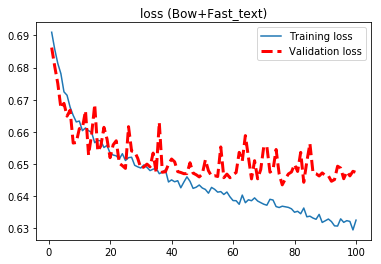

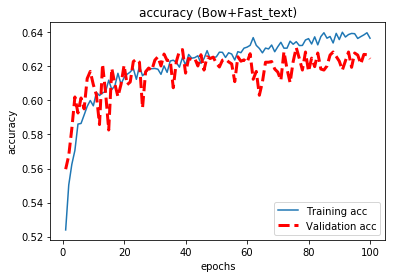

In [ ]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, 'r--', label='Validation loss', linewidth=3)
plt.title('loss (Bow+Fast_text)')
plt.legend()
plt.savefig("Training and Validation loss (Bow+Fast_text).eps", format='eps', dpi=1200)

plt.show()

plt.figure()
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc,'r--', label='Validation acc', linewidth=3)
plt.title('accuracy (Bow+Fast_text)')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig("Training and validation accuracy (Bow+Fast_text).eps", format='eps', dpi=1200)
plt.show()

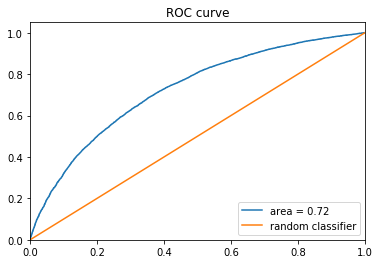

In [ ]:
#Create ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
pred_probas = model.predict_proba(x_test_)[:,0]
fpr,tpr,_ = roc_curve(y_test, pred_probas)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], label="random classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.title("ROC curve")
plt.savefig("ROC curve (Bow+Fast_text).eps", format='eps', dpi=1200)
plt.show()

In [ ]:
!ls

 adc.json
'Confusion Matrix (tf_idf).eps'
 model_fasttext.h5
 model_tf-idf.h5
'ROC curve (Bow+Fast_text).eps'
'ROC curve.eps'
'ROC curve (tf_idf).eps'
 sample_data
'Training and validation accuracy (Bow+Fast_text).eps'
'Training and validation accuracy (tf-df).eps'
'Training and Validation loss (Bow+Fast_text).eps'
'Training and Validation loss (tf-df).eps'
 wiki-news-300d-1M-subword.vec
 wiki-news-300d-1M-subword.vec.zip


In [ ]:
files.download("Training and validation accuracy (Bow+Fast_text).eps")
files.download("Training and Validation loss (Bow+Fast_text).eps")
files.download("ROC curve (Bow+Fast_text).eps")

###Confusion matrix

We can visually check the confusion matrix to understand the distribution of misclassifications.

In [ ]:
res=model.predict(x_test_)
res=res.reshape(1, -1)[0]
res_ = [int(np.round(x)) for x in res]

In [ ]:
counter = np.count_nonzero(y_pred==y_test)
counter/len(y_test)

[]

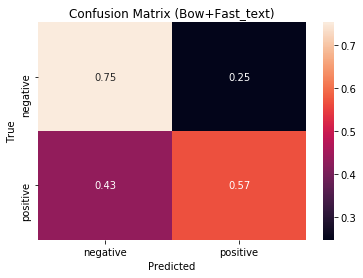

In [ ]:
y_pred = np.round(model.predict(x_test_)); y_pred

LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
  cm = tf.confusion_matrix(y_test, y_pred)
  with tf.Session() as session:
    cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True")
plt.title("Confusion Matrix (Bow+Fast_text)")
plt.savefig("Confusion Matrix (Bow+Fast_text).eps", format='eps', dpi=1200)
plt.plot()

In [ ]:
files.download("Confusion Matrix (Bow+Fast_text).eps")

### Saving the entire model and save in the drive

In [ ]:
# Save entire model to a HDF5 file
model.save('model_fasttext.h5')

In [ ]:
!ls

'Confusion Matrix (tf_idf).eps'   sample_data
 model_tf-idf.h5		 'Training and validation accuracy (tf-df).eps'
'ROC curve.eps'			 'Training and Validation loss (tf-df).eps'
'ROC curve (tf_idf).eps'


In [ ]:
files.download( "model_fasttext.h5" )

In [ ]:
!ls

adc.json  sample_data			 wiki-news-300d-1M-subword.vec.zip
gdrive	  wiki-news-300d-1M-subword.vec


## TF_IDF 

In [ ]:
%%time

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512, input_shape=(tfidf_train.shape[1], ), activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>0.66):
      print("\nReached 90% val_acc so cancelling training!")
      self.model.stop_training = True
      
callbacks = myCallback()

monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adamax(0.003), metrics=['accuracy'])

# fit network
model.fit(tfidf_train, train_df.sentiment, 
          epochs=100, 
          batch_size=64, verbose=2, 
          validation_split=0.2)#, callbacks=[monitor])


          
#           epochs=2000, 
#           batch_size=32, verbose=2, 
#           validation_split=0.2, callbacks=[monitor])

loss, acc = model.evaluate(tfidf_tst, test_df.sentiment, verbose=0)
print('Test Accuracy: %f' % (acc*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               10240512  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 10,766,337
Trainable params: 10,766,337
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/100
 - 8s - loss: 0.3369 - acc: 0.8618 - val_loss: 0.2672 - val_acc: 0.89

### Plots

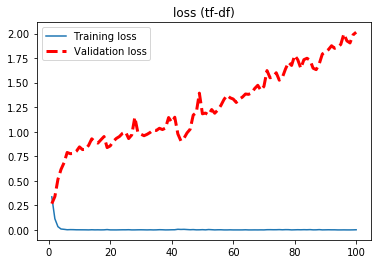

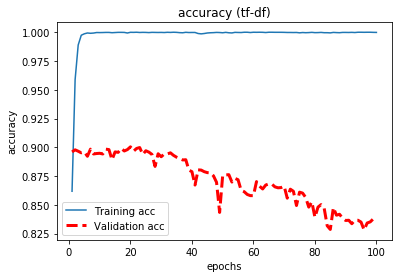

In [ ]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, 'r--',label='Validation loss',  linewidth=3)
plt.title('loss (tf-df)')
plt.legend()
plt.savefig("Training and Validation loss (tf-df).eps", format='eps', dpi=1200)
plt.show()

plt.figure()
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc,'r--', label='Validation acc', linewidth=3)
plt.title('accuracy (tf-df)')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig("Training and validation accuracy (tf-df).eps", format='eps', dpi=1200)
plt.show()

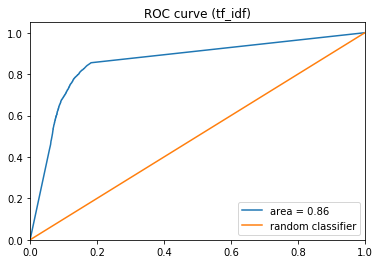

In [ ]:
#Create ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
pred_probas = model.predict_proba(tfidf_tst)[:,0]
fpr,tpr,_ = roc_curve(test_df.sentiment, pred_probas)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], label="random classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.title("ROC curve (tf_idf)")
plt.savefig("ROC curve (tf_idf).eps", format='eps', dpi=1200)
plt.show()

In [ ]:
model.predict(tfidf_tst[:,:])

array([[9.9999994e-01],
       [2.9802322e-08],
       [0.0000000e+00],
       ...,
       [0.0000000e+00],
       [3.5142303e-03],
       [0.0000000e+00]], dtype=float32)

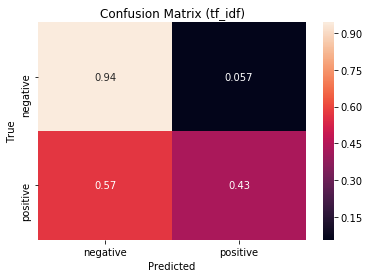

In [ ]:
LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
  cm = tf.confusion_matrix(test_df.sentiment,
                           model.predict(tfidf_tst[:,:]))
  with tf.Session() as session:
    cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.title("Confusion Matrix (tf_idf)")
plt.xlabel("Predicted");
plt.ylabel("True");
plt.savefig("Confusion Matrix (tf_idf).eps", format='eps', dpi=1200)
plt.show()

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [ ]:
(0.95+0.28)/(0.95+0.28+0.049+0.72)

0.6153076538269134

In [ ]:
# accuracy = accuracy_score(tfidf_tst, test_df.sentiment)
# print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
# precision = precision_score(tfidf_tst, test_df.sentiment)
# print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(tfidf_tst, test_df.sentiment)
print('Recall: %f' % recall)

In [ ]:
!ls

'Confusion Matrix (tf_idf).eps'   sample_data
 model_tf-idf.h5		 'Training and validation accuracy (tf-df).eps'
'ROC curve.eps'			 'Training and Validation loss (tf-df).eps'
'ROC curve (tf_idf).eps'


In [ ]:
files.download('Training and validation accuracy (tf-df).eps')
files.download("Training and Validation loss (tf-df).eps")
files.download("ROC curve (tf_idf).eps")
files.download("Confusion Matrix (tf_idf).eps")

files.download('model_tf-idf.h5')

# Small Example 

A small example for understanding of how Tokenize work

### Word level

In [ ]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
samples_essay= ['Salomon likes to learn new things. Djeff likes that too', 
            'Salomon also likes to learn Karateka']
sample_wiki = ["John likes to watch movies. Mary likes movies too.", 
               "John also likes to watch football games."]

sample_presentation =["That which we call a rose by any other name would smell as weet.",
                     "Good night sweet prince.",
                     "Parting is such sweet sorrow."] 


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sample_presentation)
sequences = tokenizer.texts_to_sequences(sample_presentation)
bag_of_word_results = tokenizer.texts_to_matrix(sample_presentation, mode='freq')
tf_idf_results = tokenizer.texts_to_matrix(sample_presentation, mode='tfidf')

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 22 unique tokens.


In [ ]:
sequences

[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [16, 17, 1, 18],
 [19, 20, 21, 1, 22]]

In [ ]:
bag_of_word_results

array([[0.        , 0.        , 0.07142857, 0.07142857, 0.07142857,
        0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
        0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
        0.07142857, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.25      , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.25      , 0.25      , 0.25      , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.2       , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.2       ,
        0.2       , 0.2       , 0.2       ]])

In [ ]:
tf_idf_results

array([[0.        , 0.        , 0.91629073, 0.91629073, 0.91629073,
        0.91629073, 0.91629073, 0.91629073, 0.91629073, 0.91629073,
        0.91629073, 0.91629073, 0.91629073, 0.91629073, 0.91629073,
        0.91629073, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.69314718, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.91629073, 0.91629073, 0.91629073, 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.69314718, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.91629073,
        0.91629073, 0.91629073, 0.91629073]])

In [ ]:
len(word_index)

22

In [ ]:
bag_of_word_results.shape

(2, 12)

In [ ]:
# results

### Caracter level

In [ ]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 17 unique tokens.


In [ ]:
sequences

[[2, 4, 3, 1, 9, 5, 2, 1, 10, 5, 2, 1, 6, 11, 1, 2, 4, 3, 1, 7, 5, 2, 8],
 [2,
  4,
  3,
  1,
  12,
  6,
  13,
  1,
  5,
  2,
  3,
  1,
  7,
  14,
  1,
  4,
  6,
  7,
  3,
  15,
  6,
  16,
  17,
  8]]

In [ ]:
one_hot_results

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
        1., 1.]])

In [ ]:
word_index

{' ': 1,
 't': 2,
 'e': 3,
 'h': 4,
 'a': 5,
 'o': 6,
 'm': 7,
 '.': 8,
 'c': 9,
 's': 10,
 'n': 11,
 'd': 12,
 'g': 13,
 'y': 14,
 'w': 15,
 'r': 16,
 'k': 17}

##  hashing trick

In [ ]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
#         Hashes the word into a 
#         random integer index 
#         between 0 and 1,000
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.


# <h2>About the Authors:</h2> 

<a href="https://salomonkabongo.wixsite.com/datascientist">Salomon Kabongo KABENAMUALU</a>, Master degree student at <a href="https://aims.ac.za/">the African Institute for mathematical SCiences (AIMS South Africa)</a> his research focused on the use machine learning technique in the field of Natural Language Processing.

References : <a href="https://machinelearningmastery.com/deep-learning-bag-of-words-model-sentiment-analysis/"> How to Develop a Deep Learning Bag-of-Words Model for Predicting Movie Review Sentiment</a>

Copyright &copy; 2019. This notebook and its source code are released under the terms of the <a href="https://www.apache.org/licenses/LICENSE-2.0">Apache License 2.0</a>.